# Kaggle - Brain Tumor MRI Dataset

You can find the dataset and some informations about on the [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

For details on steps below, please see documentation in the *docs* directory.

## Google Collab setup
### Installations

In [66]:
#!pip install ipynbname

### Data location

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
import os
os.listdir('/content/drive/MyDrive/data/Brain Tumor MRI')

['raw.dvc', 'data']

## General

In [99]:
import os
import numpy as np
import pandas as pd
from collections import OrderedDict
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import skew, kurtosis
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

In [70]:
import tensorflow as tf
print("Version:", tf.__version__)
print("CPU:", tf.config.list_physical_devices('CPU'))
print("GPU:", tf.config.list_physical_devices('GPU'))


Version: 2.19.0
CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU: []


In [71]:
# path management
PROJECT_ROOT = '/content/drive/MyDrive/data/Brain Tumor MRI'
RAW_DIR = PROJECT_ROOT + "/data/raw"
PREP_DIR = PROJECT_ROOT + "/data/processed"

CLASSES = ["notumor", "glioma", "meningioma", "pituitary"]

# parameters
IMG_SIZE = 260
SEED = 42
SPLIT = [0.7, 0.30]  # train - validation -> test data are always in a separated directory
LOW_CLIP = -1.3045
HIGH_CLIP = 3.0091

## Preprocessing

### Split train/validation

In [72]:
# get all images in sub dir "training"
train_dir = RAW_DIR + "/Training"
all_paths = []

for class_name in os.listdir(train_dir):  # ex: glioma, meningioma, ...
    folder = os.path.join(train_dir, class_name)

    for img_name in os.listdir(folder):
        all_paths.append( (os.path.join(folder, img_name), class_name) )

df_train = pd.DataFrame(all_paths, columns=["filepath", "label"])

# 2. Stratified split → Train + Validation
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train["label"],
    random_state=42
)

print(train_df.shape, val_df.shape)

(4569, 2) (1143, 2)


In [73]:
train_df['label'].value_counts(normalize=True)

,proportion
label,
notumor,0.279273
pituitary,0.254979
meningioma,0.234406
glioma,0.231342


In [74]:
val_df['label'].value_counts(normalize=True)

,proportion
label,
notumor,0.279090
pituitary,0.255468
meningioma,0.234471
glioma,0.230971


## Preprocessing pipeline

In [75]:
classes_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(CLASSES),                     # strings
        values=tf.constant(range(len(CLASSES))),       # int32
    ),
    default_value=-1  # en cas d'erreur
)

In [76]:
# EDA version has been change to be compatible with Tensorflow
def crop_black_background_tf(img, thresh=10):
    """
    Crop black background of an image.
    img: tf.Tensor of shape [H, W, C] or [H, W], dtype=tf.float32
    """
    # Convert to grayscale si nécessaire
    if img.shape[-1] == 3:
        img_gray = tf.image.rgb_to_grayscale(img)
    else:
        img_gray = img

    # Create a pixel mask > thresh
    mask = img_gray > thresh

    # Find non-zero coordinates
    coords = tf.where(mask[:, :, 0])  # coords pixels True

    # Security if black image
    def crop():
        y0 = tf.reduce_min(coords[:, 0])
        x0 = tf.reduce_min(coords[:, 1])
        y1 = tf.reduce_max(coords[:, 0])
        x1 = tf.reduce_max(coords[:, 1])
        return img[y0:y1+1, x0:x1+1, :]

    def no_crop():
        return img

    return tf.cond(tf.shape(coords)[0] > 0, crop, no_crop)

def preprocess_image_tf(path, label, low_clip, high_clip, classes, target_size=(260, 260)):
    """
    Full TF preprocessing pipeline:
    - read
    - crop black background
    - resize
    - convert to float32
    - z-score normalize (image-wise)
    - clip using percentiles
    """
    # 1. Read image
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  # [H,W,3]

    # 2. Convert to float32 [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 3. Crop black background
    img = crop_black_background_tf(img, thresh=10)

    # 4. Resize
    img = tf.image.resize(img, target_size, method='area')

    # 5. Z-score normalize per image
    mean, variance = tf.nn.moments(img, axes=[0,1,2])
    std = tf.sqrt(variance)
    std = tf.maximum(std, 1e-6)  # sécurité pour éviter division par zéro
    img = (img - mean) / std

    # 6. Clip
    img = tf.clip_by_value(img, low_clip, high_clip)

    # 7. Encoding label
    label = classes.lookup(label)

    return img, label

def df_to_tf_dataset(df):
    """
    Convert the pandas DataFrame (with path and label) to a tf.data.Dataset
    """
    paths = df['filepath'].values
    labels = df['label'].values
    return tf.data.Dataset.from_tensor_slices((paths, labels))

In [77]:
train_ds = df_to_tf_dataset(train_df)
val_ds   = df_to_tf_dataset(val_df)

train_ds = train_ds.map(
    lambda path, label: preprocess_image_tf(
        path, label, LOW_CLIP, HIGH_CLIP, classes_table
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

val_ds = val_ds.map(
    lambda path, label: preprocess_image_tf(
        path, label, LOW_CLIP, HIGH_CLIP, classes_table
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

### Calculate clipping bounds on trainset

In [78]:
train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(260, 260, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [79]:
def get_global_intensity_distrib_tf(dataset, nb_deci=4):
    distrib = {}

    # Parcours du dataset TF (batch ou image par image)
    for img, label in tqdm.tqdm(dataset):
        # Convertir en numpy
        img_np = img.numpy()  # (H, W, C)

        # Aplatir
        pixels = img_np.flatten()

        # Histogramme
        unique, counts = np.unique(pixels, return_counts=True)

        # Stocker dans le dictionnaire
        for val, count in zip(unique, counts):
            val = round(float(val), nb_deci)  # attention au dtype TF → float
            if val not in distrib:
                distrib[val] = count
            else:
                distrib[val] += count

    return OrderedDict(sorted(distrib.items()))


def get_percentiles_from_distrib(distrib, low_bound=0.01, high_bound=0.99):
    pixel_vals = np.array(list(distrib.keys()))
    counts = np.array(list(distrib.values()))

    # create a frequency vector (without storing everything)
    frequency_v = np.cumsum(counts) / counts.sum()

    # find the p1=1% and p99=99% thresholds
    low_val = pixel_vals[np.searchsorted(frequency_v, low_bound)]
    high_val = pixel_vals[np.searchsorted(frequency_v, high_bound)]

    return low_val, high_val

In [80]:
#distrib = get_global_intensity_distrib_tf(train_ds)

In [81]:
"""
plt.figure()
bar_cntnr = plt.bar(*zip(*distrib.items()))
plt.title("Normalized intensity distribution")
"""

'\nplt.figure()\nbar_cntnr = plt.bar(*zip(*distrib.items()))\nplt.title("Normalized intensity distribution")\n'

In [82]:
#low, high = get_percentiles_from_distrib(distrib)
#print(f'{low}, {high}')

## Few visual verifications

### Show exemples in each classes

In [88]:
def display_random_images_per_class_reservoir(dataset, class_names, n_per_class=10):
    """
    Displays n_per_class random images per class without loading the entire dataset into memory.
    Uses Reservoir Sampling.
    """
    reservoir = {i: [] for i in range(len(class_names))}
    counts = {i: 0 for i in range(len(class_names))}  # counter for each class

    for img, label in tqdm.tqdm(dataset):
        label = int(label.numpy())
        counts[label] += 1
        if len(reservoir[label]) < n_per_class:
            reservoir[label].append(img.numpy())
        else:
            # Random replacement in the reservoir
            j = random.randint(0, counts[label]-1)
            if j < n_per_class:
                reservoir[label][j] = img.numpy()

    # Display
    for class_idx, class_name in enumerate(class_names):
        sampled_imgs = reservoir[class_idx]
        if len(sampled_imgs) == 0:
            print(f"Aucune image trouvée pour la classe : {class_name}")
            continue

        print(f"Classe : {class_name} ({len(sampled_imgs)} images affichées)")
        plt.figure(figsize=(12, 3))
        for i, img in enumerate(sampled_imgs):
            plt.subplot(1, n_per_class, i + 1)
            plt.imshow(img)
            plt.axis("off")
        plt.show()

100%|██████████| 4569/4569 [00:42<00:00, 108.68it/s]


Classe : notumor (10 images affichées)


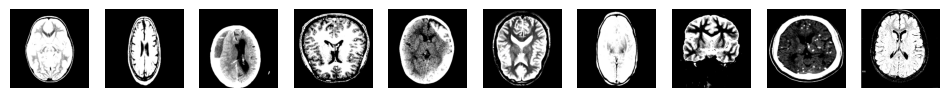

Classe : glioma (10 images affichées)


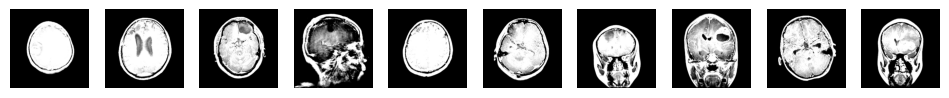

Classe : meningioma (10 images affichées)


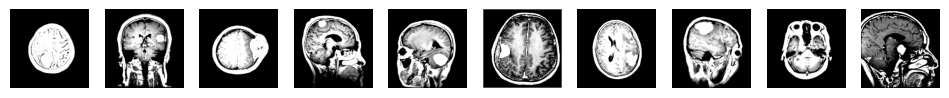

Classe : pituitary (10 images affichées)


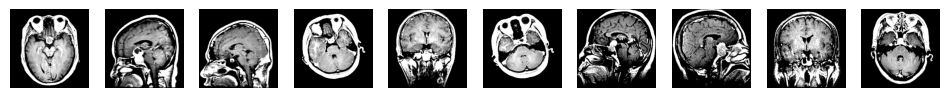

In [89]:
display_random_images_per_class_reservoir(train_ds, CLASSES, n_per_class=10)

### PCA aspect (to compare with EDA)

In [91]:
def compute_intensity_stats_tf(dataset, classes):
    """
    Compute per-image intensity statistics for a tf.data.Dataset.
    dataset: tf.data.Dataset of (img, label)
    classes: list of class names corresponding to label indices
    """
    records = []

    for img, label in tqdm.tqdm(dataset):
        # Convert TensorFlow tensor to numpy
        img_np = img.numpy()  # shape: (H,W,C)

        # Convert to grayscale if needed
        if img_np.ndim == 3 and img_np.shape[-1] == 3:
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img_np

        mean_val = img_gray.mean()
        std_val = img_gray.std()
        min_val = img_gray.min()
        max_val = img_gray.max()

        img_flat = img_gray.flatten()
        skew_v = float(skew(img_flat))
        kurt_v = float(kurtosis(img_flat))

        # Decode label if it's an int index
        label_idx = int(label.numpy()) if tf.is_tensor(label) else label
        records.append({
            "class": classes[label_idx],
            "mean": mean_val,
            "std": std_val,
            "min": min_val,
            "max": max_val,
            "skew": skew_v,
            "kurt": kurt_v
        })

    return pd.DataFrame(records)

In [96]:
df_intensity = compute_intensity_stats_tf(train_ds, CLASSES)
df_intensity

100%|██████████| 4569/4569 [01:12<00:00, 62.81it/s] 


,class,mean,std,min,max,skew,kurt
0,meningioma,-4.912828e-03,0.983334,-0.687200,3.009100,1.243556,0.389802
1,notumor,-7.324833e-04,0.997732,-1.212555,3.009100,0.676727,-0.099967
2,glioma,-3.189724e-03,0.988937,-0.930838,3.009100,0.731493,-0.419580
3,meningioma,-8.564298e-03,0.970544,-0.742072,3.009100,1.163874,0.469926
4,pituitary,-4.863749e-03,0.983604,-1.207360,3.009100,0.654143,-0.081891
...,...,...,...,...,...,...,...
4564,pituitary,-5.739036e-03,0.980552,-0.966747,3.009100,1.027392,0.569400
4565,notumor,-3.069816e-08,1.000000,-0.830462,2.550559,0.775635,-0.726660
4566,notumor,-2.753191e-04,0.999164,-1.001691,3.009100,0.822574,0.244357
4567,meningioma,-4.839555e-03,0.983817,-0.993836,3.009100,0.899324,0.248259


In [97]:
def do_PCA(df_stats, pca_components=2):
    features = df_stats[["mean", "std", "skew", "kurt"]].values
    labels = df_stats["class"].values

    # Normalization
    scaled = StandardScaler().fit_transform(features)

    pca = PCA(n_components=pca_components)
    coords = pca.fit_transform(scaled)

    df_stats["pc1"] = coords[:, 0]
    df_stats["pc2"] = coords[:, 1]

    # Visualisation
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_stats, x="pc1", y="pc2", hue="class", alpha=0.5)
    plt.title("PCA on globals stats")
    plt.show()

    print("Explained variance :", pca.explained_variance_ratio_)

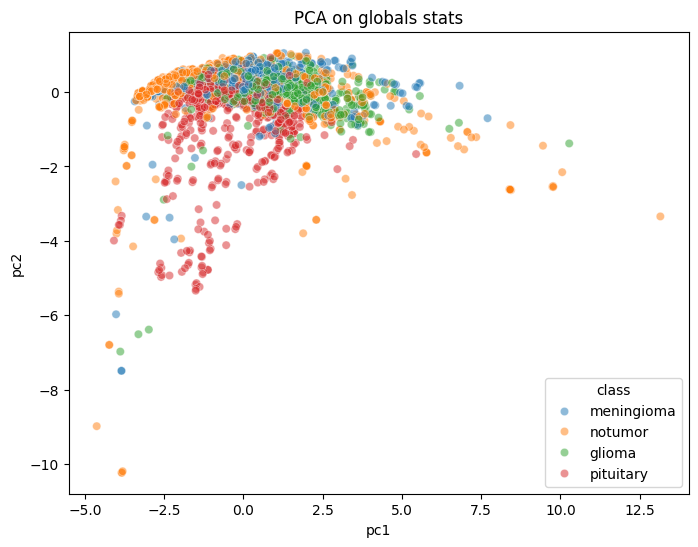

Explained variance : [0.67321465 0.1721153 ]


In [100]:
do_PCA(df_intensity)